### 논문 구현
- data는 제공된 것 사용

In [14]:
import pandas as pd
df = pd.read_csv("df_claim_cpc_1400.csv", encoding="latin1")
df_claim_test = pd.read_csv("df_claim_cpc_test.csv", encoding="latin1")
df_claim_train = pd.read_csv("df_claim_cpc_train.csv", encoding="latin1")

In [15]:
df.head(2)

,patent_id,section_id,subsection_id,group_id,subgroup_id,category,sequence,text,uuid
0,6837198,['Y'],['Y10'],['Y10T'],['Y10T74/18288'],['additional'],[4],A variable valve train ( 1 ) for load control ...,2c4c4ae4-ebbe-11ea-a344-121df0c29c1e
1,6837201,['F'],['F01'],['F01M'],['F01M9/106'],['inventional'],[0],An intake valve for a combustion engine having...,090ad87c-ebb6-11ea-a344-121df0c29c1e


In [17]:
df_claim_test.head(2)

,id,date,text,A01B,A01C,A01D,A01F,A01G,A01H,A01J,...,Y02B,Y02C,Y02D,Y02E,Y02P,Y02T,Y02W,Y04S,Y10S,Y10T
0,9289350,2016-03-22,1. An apparatus for generating air pressure an...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9579560,2017-02-28,1. A user-customizable audio-visual puzzle com...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_claim_train.head(2)

,id,date,text,A01B,A01C,A01D,A01F,A01G,A01H,A01J,...,Y02B,Y02C,Y02D,Y02E,Y02P,Y02T,Y02W,Y04S,Y10S,Y10T
0,8788730,2014-07-22,1. A method for sending a keycode of a non-key...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8621421,2013-12-31,1. A method executed at least in part in a com...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')
test_embeddings = model.encode(df_claim_test.text, convert_to_tensor= True, show_progress_bar= True)
claim_embeddings = model.encode(df_claim_train.text, convert_to_tensor=True, show_progress_bar=True)
stored_patent_test_embeddings_id = df_claim_test['id']
stored_patent_train_embeddings_id = df_claim_train['id']

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [21]:
import scipy.spatial
import numpy as np
import os, json
import glob
import re
import torch
import pandas as pd
from tokenizers import Tokenizer
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
import pandas as pd
import torch
import random
import itertools
import pickle
import time

start = time.time()

F1Measure_list = []
Recall_list = []
Accuracy_list = []
Precision_list = []
Hamming_Loss_list = []


def get_top_n_similar_patents_df(new_claim, claim_embeddings):
    search_hits_list = []
    search_hits = util.semantic_search(new_claim, claim_embeddings, 10000, 5000000, 20)
    top_claim_order = []
    top_claim_ids = []
    top_similarity_scores = []
    for item in range(len(search_hits[0])):
        top_claim_order = search_hits[0][item].get('corpus_id')
        top_claim_ids.append(stored_patent_train_embeddings_id[top_claim_order])
        top_similarity_scores.append(search_hits[0][item].get('score'))
        
    top_100_similar_patents_df = pd.DataFrame({
        'top_claim_ids': top_claim_ids,
        'cosine_similarity': top_similarity_scores,
    })

        
    
    return top_100_similar_patents_df

def F1Measure(y_true, y_pred):
    save_F1 = []
    temp = 0
    for i in range(y_true.shape[0]):
        if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
            continue
        temp_save = (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
        save_F1.append(temp_save)
        temp += temp_save

    save_F1 = pd.DataFrame(save_F1)
    save_F1_ids = pd.concat([result, save_F1], axis=1, ignore_index=True)
    return temp/ y_true.shape[0]

def Recall(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_pred[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
    return temp/ y_true.shape[0]

def Precision(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_true[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
    return temp/ y_true.shape[0]

def Hamming_Loss(y_true, y_pred):
    temp=0
    for i in range(y_true.shape[0]):
        temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return temp/(y_true.shape[0] * y_true.shape[1])

def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

df_claim_train

claims = list(df_claim_train.text)
patent_id = list(df_claim_train.id)

listofpredictdfs = []

start = time.time()

for i in range(len(df_claim_test[:100])):
    get_top_n_similar_patents_df_predict = get_top_n_similar_patents_df(np.array(test_embeddings[i]).reshape(1,-1), claim_embeddings)
    result = pd.merge(get_top_n_similar_patents_df_predict, df_claim_train, left_on='top_claim_ids',right_on='id',how='left',suffixes=('_left','_right'))
    locals()["predict_n"+str(i)] = result.copy()
    listofpredictdfs.append("predict_n"+str(i))

df = pd.concat(map(lambda x: eval(x), listofpredictdfs),keys= listofpredictdfs ,axis=0)

top_k = 20
for k in range(top_k):
    top_n = k
    predict = pd.DataFrame(columns= df_claim_test.columns[6:])
    for item in range(len(listofpredictdfs)):
        k_similar_patents = df.xs(listofpredictdfs[item]).nlargest(top_n, ['cosine_similarity'])
        result_k_similar_patents = pd.DataFrame(0, index=np.arange(1),columns= k_similar_patents.columns[8:])
        for i in range(top_n):
            result_k_similar_patents  = result_k_similar_patents + k_similar_patents.iloc[i, 8:].values
        result_k_similar_patents_df = pd.DataFrame(result_k_similar_patents, columns= k_similar_patents.columns[8:])
        result_k_similar_patents_df.insert(0, "input_aptent_id", dftest.id.iloc[item], True)
        locals()["predict"+str(item)] = result_k_similar_patents_df.copy()
        predict = pd.concat([predict, locals()["predict"+str(item)]], ignore_index=True)
        result_k_similar_patents_df = result_k_similar_patents_df[0:0]
    data = torch.tensor((predict.to_numpy()).astype(float), dtype=torch.float32)
    m = nn.Sigmoid()
    output = m(data)
    output = (output>0.9).float()
    output_df = pd.DataFrame(output, columns=predict.columns).astype(float) 
    y_pred = output_df.iloc[:, :-1].to_numpy()
    y_true = df_claim_test.iloc[:100, 6:].to_numpy()
    result = pd.concat([output_df, df_claim_test], axis=1, ignore_index=True)    
    F1Measure_list.append(F1Measure(y_true,y_pred))
    Recall_list.append(Recall(y_true,y_pred))
    Accuracy_list.append(Accuracy(y_true, y_pred))
    Precision_list.append(Precision(y_true,y_pred))
    Hamming_Loss_list.append(Hamming_Loss(y_true, y_pred))
    end = time.time()
    print(f"Runtime of the program is {end - start}")
    print("F1Measure: ", F1Measure_list[top_n])
    print("Recall: ", Recall_list[top_n])
    print("Accuracy: ", Accuracy_list[top_n])
    print("Precision: ", Precision_list[top_n])
    print("Hamming_Loss: ", Hamming_Loss_list[top_n])
    
output_d_metrics = {'F1Measure':F1Measure_list,'Recall_list':Recall_list, 'Accuracy_list':Accuracy_list,'Precision_list':Precision_list,'Hamming_Loss_list':Hamming_Loss_list}
output_df_metrics = pd.DataFrame(output_d_metrics)

Runtime of the program is 9.38038945198059
F1Measure:  0.0
Recall:  0.0
Accuracy:  0.0
Precision:  0.0
Hamming_Loss:  0.0028787878787878787
Runtime of the program is 9.865803003311157
F1Measure:  0.0
Recall:  0.0
Accuracy:  0.0
Precision:  0.0
Hamming_Loss:  0.0028787878787878787
Runtime of the program is 10.428145408630371
F1Measure:  0.0
Recall:  0.0
Accuracy:  0.0
Precision:  0.0
Hamming_Loss:  0.0028787878787878787
Runtime of the program is 11.21072006225586
F1Measure:  0.10566666666666664
Recall:  0.13
Accuracy:  0.0925
Precision:  0.09916666666666667
Hamming_Loss:  0.002696969696969697
Runtime of the program is 11.94478726387024
F1Measure:  0.18966666666666662
Recall:  0.24
Accuracy:  0.165
Precision:  0.17166666666666663
Hamming_Loss:  0.0025909090909090908
Runtime of the program is 12.764697074890137
F1Measure:  0.23866666666666667
Recall:  0.29
Accuracy:  0.2075
Precision:  0.22083333333333335
Hamming_Loss:  0.0026363636363636363
Runtime of the program is 13.559588193893433
F1

In [22]:
output_df_metrics.to_csv("original_output.csv",index=False)

In [27]:
import pandas as pd

# 청크 크기 설정
chunksize = 10000

# 청크 단위로 파일 읽기
chunk_list = []  # 청크를 저장할 리스트

for chunk in pd.read_csv('pgpub_claims_fulltext.csv',nrows=10000 ,chunksize=chunksize):
    # 청크 단위로 필요한 데이터 처리
    chunk_list.append(chunk)

# 청크를 합쳐서 하나의 데이터프레임으로 만들기
df = pd.concat(chunk_list, ignore_index=True)


In [28]:
df.tail()

,pub_no,appl_id,claim_no,claim_txt,dependencies,ind_flg
9995,20010000457,9729040,24,"A system according to claim 21 , wherein said ...",21,0
9996,20010000457,9729040,19,"A system according to claim 13 , wherein said ...",13,0
9997,20010000457,9729040,1,A method for dynamic allocation of transmissio...,NaN,1
9998,20010000457,9729040,16,"A system according to claim 13 , further compr...",13,0
9999,20010000457,9729040,12,"A method according to claim 1 , further compri...",1,0


In [29]:
df['appl_id'].nunique()

454

In [ ]:
import requests
from tqdm import tqdm

condition = '&f=["app_number","patent_id","cpc_section_id","cpc_group_id","cpc_subgroup_id","cpc_category"]'
url_post = 'https://api.patentsview.org/patents/query?q={"patent_number":"'


dict_list=[]

for i in tqdm(range(len(df))):
    num = df['appl_id'][i]
    api_url = url_post + str(num) + '"}' + condition
    api_data = requests.get(api_url)
    api_json = api_data.json()
    if api_json['patents'] != None:
        dict_list.extend(api_json['patents']) #된거
    
    if i % 100 == 0:
        final = pd.DataFrame.from_dict(dict_list)

final

In [89]:
import pandas as pd
df = pd.read_csv("uspto_all.csv")
df_claim_test = pd.read_csv("uspto_test.csv")
df_claim_train = pd.read_csv("uspto_train.csv")

C:\Users\Daybi\AppData\Local\Temp\ipykernel_5116\1358502017.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("uspto_all.csv")


In [90]:
df_claim_test = df_claim_test[:300]
df_claim_train = df_claim_train[:700]

df_claim_train = df_claim_train.rename(columns={"claim_txt" : "text"})
df_claim_test= df_claim_test.rename(columns={"claim_txt" : "text"})

df_claim_train.to_csv("df_claim_train700.csv", index=False)
df_claim_test.to_csv("df_claim_test300.csv", index = False)

In [91]:
df_claim_test = pd.read_csv("df_claim_test300.csv")
df_claim_train = pd.read_csv("df_claim_train700.csv")

In [92]:
df_claim_test

,pub_no,id,claim_no,text,dependencies,ind_flg,A01K,A01M,A44C,A45D,...,H10N,Y02A,Y02B,Y02D,Y02E,Y02P,Y02T,Y04S,Y10S,Y10T
0,20010000224,9727027,40,"ng tool according to claim 39 , wherein said i...",39.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20010000002,9726341,30,"e of claim 22 , wherein at least one of the se...",22.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20010000189,9730644,12,le of claim 11 wherein the web has single bior...,11.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20010000219,9726642,50,m of claim 49 wherein the decoder block compri...,49.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20010000335,9725486,23,ectric conversion device comprising: an ultraf...,NaN,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,20010000187,9726146,8,m as set forth in claim 7 wherein the position...,7.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,20010000224,9727027,17,"ng tool according to claim 11 , wherein said c...",11.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,20010000112,9726663,1,-gate flash memory cell having a floating Poly...,NaN,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,20010000068,9729469,18,ectric conversion apparatus comprising: (a) a ...,NaN,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
df_claim_train

,pub_no,id,claim_no,text,dependencies,ind_flg,A01K,A01M,A44C,A45D,...,H10N,Y02A,Y02B,Y02D,Y02E,Y02P,Y02T,Y04S,Y10S,Y10T
0,20010000243,9731905,27,lm transistor having a laminated structure com...,NaN,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20010000231,9727487,6,"ss of claim 5 , wherein said solvent is ethanol.",5.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20010000393,9737877,7,d of claim 3 wherein said encapsulating materi...,3.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,20010000219,9726642,20,d of claim 19 wherein the non-adaptive filter ...,19,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20010000199,9727539,6,"d recited in claim 2 , wherein temperature of ...",2.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,20010000145,9731677,39,coffee extract obtained by extraction of a qu...,NaN,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
696,20010000345,9727900,34,"of treating a disorder according to claim 33 ,...",33.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
697,20010000187,9726146,66,ical lead for providing electrical stimulation...,NaN,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
698,20010000408,9729853,53,of detecting a dispensed object according to c...,41.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')
test_embeddings = model.encode(df_claim_test["text"].tolist(), convert_to_tensor = True, show_progress_bar= True)
claim_embeddings = model.encode(df_claim_train["text"].tolist(), convert_to_tensor=True, show_progress_bar=True)
stored_patent_test_embeddings_id = df_claim_test['id']
stored_patent_train_embeddings_id = df_claim_train['id']

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

In [95]:
import scipy.spatial
import numpy as np
import os, json
import glob
import re
import torch
import pandas as pd
from tokenizers import Tokenizer
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
import pandas as pd
import torch
import random
import itertools
import pickle
import time

start = time.time()

F1Measure_list = []
Recall_list = []
Accuracy_list = []
Precision_list = []
Hamming_Loss_list = []


def get_top_n_similar_patents_df(new_claim, claim_embeddings):
    search_hits_list = []
    search_hits = util.semantic_search(new_claim, claim_embeddings, 10000, 5000000, 20)
    top_claim_order = []
    top_claim_ids = []
    top_similarity_scores = []
    for item in range(len(search_hits[0])):
        top_claim_order = search_hits[0][item].get('corpus_id')
        top_claim_ids.append(stored_patent_train_embeddings_id[top_claim_order])
        top_similarity_scores.append(search_hits[0][item].get('score'))
        
    top_100_similar_patents_df = pd.DataFrame({
        'top_claim_ids': top_claim_ids,
        'cosine_similarity': top_similarity_scores,
    })

        
    
    return top_100_similar_patents_df

def F1Measure(y_true, y_pred):
    save_F1 = []
    temp = 0
    for i in range(y_true.shape[0]):
        if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
            continue
        temp_save = (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
        save_F1.append(temp_save)
        temp += temp_save

    save_F1 = pd.DataFrame(save_F1)
    save_F1_ids = pd.concat([result, save_F1], axis=1, ignore_index=True)
    return temp/ y_true.shape[0]

def Recall(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_pred[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
    return temp/ y_true.shape[0]

def Precision(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_true[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
    return temp/ y_true.shape[0]

def Hamming_Loss(y_true, y_pred):
    temp=0
    for i in range(y_true.shape[0]):
        temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return temp/(y_true.shape[0] * y_true.shape[1])

def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

df_claim_train

claims = list(df_claim_train.text)
patent_id = list(df_claim_train.id)

listofpredictdfs = []

start = time.time()

for i in range(len(df_claim_test[:100])):
    get_top_n_similar_patents_df_predict = get_top_n_similar_patents_df(np.array(test_embeddings[i]).reshape(1,-1), claim_embeddings)
    result = pd.merge(get_top_n_similar_patents_df_predict, df_claim_train, left_on='top_claim_ids',right_on='id',how='left',suffixes=('_left','_right'))
    locals()["predict_n"+str(i)] = result.copy()
    listofpredictdfs.append("predict_n"+str(i))

df = pd.concat(map(lambda x: eval(x), listofpredictdfs),keys= listofpredictdfs ,axis=0)

top_k = 20
for k in range(top_k):
    top_n = k
    predict = pd.DataFrame(columns= df_claim_test.columns[6:])
    for item in range(len(listofpredictdfs)):
        k_similar_patents = df.xs(listofpredictdfs[item]).nlargest(top_n, ['cosine_similarity'])
        result_k_similar_patents = pd.DataFrame(0, index=np.arange(1),columns= k_similar_patents.columns[8:])
        for i in range(top_n):
            result_k_similar_patents  = result_k_similar_patents + k_similar_patents.iloc[i, 8:].values
        result_k_similar_patents_df = pd.DataFrame(result_k_similar_patents, columns= k_similar_patents.columns[8:])
        result_k_similar_patents_df.insert(0, "input_aptent_id", df_claim_test.id.iloc[item], True)
        locals()["predict"+str(item)] = result_k_similar_patents_df.copy()
        predict = pd.concat([predict, locals()["predict"+str(item)]], ignore_index=True)
        result_k_similar_patents_df = result_k_similar_patents_df[0:0]
    data = torch.tensor((predict.to_numpy()).astype(float), dtype=torch.float32)
    m = nn.Sigmoid()
    output = m(data)
    output = (output>0.9).float()
    output_df = pd.DataFrame(output, columns=predict.columns).astype(float) 
    y_pred = output_df.iloc[:, :-1].to_numpy()
    y_true = df_claim_test.iloc[:100, 6:].to_numpy()
    result = pd.concat([output_df, df_claim_test], axis=1, ignore_index=True)    
    F1Measure_list.append(F1Measure(y_true,y_pred))
    Recall_list.append(Recall(y_true,y_pred))
    Accuracy_list.append(Accuracy(y_true, y_pred))
    Precision_list.append(Precision(y_true,y_pred))
    Hamming_Loss_list.append(Hamming_Loss(y_true, y_pred))
    end = time.time()
    print(f"Runtime of the program is {end - start}")
    print("F1Measure: ", F1Measure_list[top_n])
    print("Recall: ", Recall_list[top_n])
    print("Accuracy: ", Accuracy_list[top_n])
    print("Precision: ", Precision_list[top_n])
    print("Hamming_Loss: ", Hamming_Loss_list[top_n])
    
output_d_metrics = {'F1Measure':F1Measure_list,'Recall_list':Recall_list, 'Accuracy_list':Accuracy_list,'Precision_list':Precision_list,'Hamming_Loss_list':Hamming_Loss_list}
output_df_metrics = pd.DataFrame(output_d_metrics)

Runtime of the program is 3.04114031791687
F1Measure:  0.0
Recall:  0.0
Accuracy:  0.0
Precision:  0.0
Hamming_Loss:  0.007518796992481203
Runtime of the program is 3.4727020263671875
F1Measure:  0.0
Recall:  0.0
Accuracy:  0.0
Precision:  0.0
Hamming_Loss:  0.007518796992481203
Runtime of the program is 3.9212710857391357
F1Measure:  0.0
Recall:  0.0
Accuracy:  0.0
Precision:  0.0
Hamming_Loss:  0.007518796992481203
Runtime of the program is 4.454772472381592
F1Measure:  0.11
Recall:  0.11
Accuracy:  0.11
Precision:  0.11
Hamming_Loss:  0.007669172932330827
Runtime of the program is 4.97520637512207
F1Measure:  0.14
Recall:  0.14
Accuracy:  0.14
Precision:  0.14
Hamming_Loss:  0.007969924812030075
Runtime of the program is 5.5892438888549805
F1Measure:  0.22
Recall:  0.22
Accuracy:  0.22
Precision:  0.22
Hamming_Loss:  0.009398496240601503
Runtime of the program is 6.199713945388794
F1Measure:  0.24333333333333335
Recall:  0.235
Accuracy:  0.235
Precision:  0.26
Hamming_Loss:  0.00977

In [96]:
output_df_metrics.to_csv("eco_output1000.csv",index=False)

### 1단계 : 새로운 데이터
USPTO API

In [116]:
# ecomomic dataset load
import pandas as pd

# 청크 크기 설정
chunksize = 1000  # 예: 100,000 행씩 읽기

# 청크 단위로 파일 읽기
chunk_list = []  # 청크를 저장할 리스트

for chunk in pd.read_csv('pgpub_claims_fulltext.csv',nrows=1000 ,chunksize=chunksize):
    # 청크 단위로 필요한 데이터 처리
    chunk_list.append(chunk)

# 청크를 합쳐서 하나의 데이터프레임으로 만들기
data = pd.concat(chunk_list, ignore_index=True).rename(columns={"appl_id" : "id", "claim_txt" : "text"})
data

,pub_no,id,claim_no,text,dependencies,ind_flg
0,20010000001,9725796,11,The method of claim 10 comprising up to about ...,10,0
1,20010000001,9725796,16,The method of claim 15 wherein said sec-butano...,15,0
2,20010000001,9725796,4,The solvent mixture of claim 3 wherein said te...,3,0
3,20010000001,9725796,9,A method for cleaning an article in a vapor de...,NaN,1
4,20010000001,9725796,8,The solvent mixture of claim 7 wherein said se...,7,0
...,...,...,...,...,...,...
995,20010000052,9726638,14,"A small watercraft as in claim 1 , wherein the...",1,0
996,20010000052,9726638,20,"A small watercraft as in claim 1 , wherein the...",1,0
997,20010000052,9726638,1,A small watercraft comprising a hull including...,NaN,1
998,20010000052,9726638,17,"A small watercraft as in claim 16 , wherein th...",16,0


In [117]:
data.nunique()

pub_no           52
id               52
claim_no         60
text            985
dependencies     52
ind_flg           2
dtype: int64

In [118]:
import requests
from tqdm import tqdm

condition = '&f=["patent_id","cpc_category","cpc_section_id","cpc_subsection_id","cpc_group_id","cpc_subgroup_id"]'
url_post = 'https://api.patentsview.org/patents/query?q={"patent_number":"'


dict_list=[]

for i in tqdm(range(len(data))):
    num = data['id'][i]
    api_url = url_post + str(num) + '"}' + condition
    api_data = requests.get(api_url)
    api_json = api_data.json()
    if api_json['patents'] != None:
        dict_list.extend(api_json['patents']) #된거
    
    if i % 100 == 0:
        final = pd.DataFrame.from_dict(dict_list)

expanded_rows = []
for idx, row in final.iterrows():
    for cpc in row['cpcs']:
        expanded_row = row.drop(labels='cpcs').to_dict()
        expanded_row.update(cpc)
        expanded_rows.append(expanded_row)

# 새로운 데이터프레임으로 변환
df_claim_cpc_new_full = pd.DataFrame(expanded_rows)
df_claim_cpc_new_full = df_claim_cpc_new_full.rename(columns={"patent_id" : "id"})

# 결과 출력
df_claim_cpc_new_full

100%|██████████| 1000/1000 [19:00<00:00,  1.14s/it]


,id,cpc_category,cpc_section_id,cpc_subsection_id,cpc_group_id,cpc_subgroup_id
0,9725796,inventional,B,B22,B22D,B22D25/06
1,9725796,inventional,B,B22,B22D,B22D27/006
2,9725796,additional,B,B22,B22D,B22D17/00
3,9725796,inventional,C,C22,C22C,C22C45/00
4,9725796,inventional,C,C22,C22C,C22C1/11
...,...,...,...,...,...,...
8990,9726609,inventional,G,G01,G01N,G01N21/658
8991,9726609,additional,G,G01,G01N,G01N2201/06113
8992,9726609,inventional,H,H01,H01S,H01S3/30
8993,9726609,additional,Y,Y10,Y10S,Y10S977/81


In [170]:
data2 = data[["id","text"]]
data2['id'] = data2['id'].astype(str)
df_claim_cpc_new_full['id'] = df_claim_cpc_new_full['id'].astype(str).drop_duplicates()

dcf = pd.merge(data, df_claim_cpc_new_full, on="id", how="inner")
dcf.reset_index(drop=True,inplace = True)

C:\Users\Daybi\AppData\Local\Temp\ipykernel_5116\2517978645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['id'] = data2['id'].astype(str)


In [171]:
dcf

,pub_no,id,claim_no,text,dependencies,ind_flg,cpc_category,cpc_section_id,cpc_subsection_id,cpc_group_id,cpc_subgroup_id
0,20010000001,9725796,11,The method of claim 10 comprising up to about ...,10,0,inventional,B,B22,B22D,B22D25/06
1,20010000001,9725796,16,The method of claim 15 wherein said sec-butano...,15,0,inventional,B,B22,B22D,B22D25/06
2,20010000001,9725796,4,The solvent mixture of claim 3 wherein said te...,3,0,inventional,B,B22,B22D,B22D25/06
3,20010000001,9725796,9,A method for cleaning an article in a vapor de...,NaN,1,inventional,B,B22,B22D,B22D25/06
4,20010000001,9725796,8,The solvent mixture of claim 7 wherein said se...,7,0,inventional,B,B22,B22D,B22D25/06
...,...,...,...,...,...,...,...,...,...,...,...
908,20010000047,9726609,24,"A system, comprising: a client having (a) a pr...",NaN,1,inventional,B,B82,B82Y,B82Y30/00
909,20010000047,9726609,6,"The method of claim 1 , wherein the extracting...",1,0,inventional,B,B82,B82Y,B82Y30/00
910,20010000047,9726609,17,"The computer-readable medium of claim 12 , whe...",12,0,inventional,B,B82,B82Y,B82Y30/00
911,20010000047,9726609,9,"The method of claim 1 , further comprising the...",1,0,inventional,B,B82,B82Y,B82Y30/00


In [172]:
dcf.to_csv("dcf.csv",index=False)

In [7]:

import pandas as pd
dcf = pd.read_csv('dcf.csv')

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

#Filtering just general category
# df_claim_cpc_new_full['group_id'] = df_claim_cpc_new_full.group_id.apply(lambda x:[a.split(',')[0] for a in x])
dcf['group_id'] = dcf['cpc_group_id'].str.split(',')
dcf['group_id'] = dcf['cpc_group_id'].apply(lambda x:pd.Series(x).unique())

# Tranforming output variable to one-hot encoded output features
mlb = MultiLabelBinarizer(sparse_output=True)

# Construing final dataframe
df = dcf.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(dcf.pop('group_id')),
                index=dcf.index,
                columns=mlb.classes_))
df = df.drop(["cpc_group_id","cpc_section_id","cpc_subsection_id","cpc_subgroup_id"],axis=1)
df = df.rename(columns={"patent_id" : "id"})

In [9]:
df

,pub_no,id,claim_no,text,dependencies,ind_flg,cpc_category,A41D,A61F,A61L,...,G01B,G01C,G01N,G01P,G01R,G02B,G06F,G06T,G08B,H01M
0,20010000001,9725796,11,The method of claim 10 comprising up to about ...,10,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20010000001,9725796,16,The method of claim 15 wherein said sec-butano...,15,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20010000001,9725796,4,The solvent mixture of claim 3 wherein said te...,3,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20010000001,9725796,9,A method for cleaning an article in a vapor de...,NaN,1,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20010000001,9725796,8,The solvent mixture of claim 7 wherein said se...,7,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,20010000047,9726609,24,"A system, comprising: a client having (a) a pr...",NaN,1,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
909,20010000047,9726609,6,"The method of claim 1 , wherein the extracting...",1,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
910,20010000047,9726609,17,"The computer-readable medium of claim 12 , whe...",12,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
911,20010000047,9726609,9,"The method of claim 1 , further comprising the...",1,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
categories_cols = df.columns[7:]
labels = df[categories_cols]
#Removing labels which occur only once.
#labels_to_remove_1 = labels_1[labels_1.columns[labels_1.sum(axis=0) <30]].columns

labels_to_remove = labels[labels.columns[labels.sum(axis=0) <10]].columns

In [11]:
df['text'] = df['text'].str[3:]
for item in labels_to_remove:
    df = df[df[item] != 1]

In [12]:
df

,pub_no,id,claim_no,text,dependencies,ind_flg,cpc_category,A41D,A61F,A61L,...,G01B,G01C,G01N,G01P,G01R,G02B,G06F,G06T,G08B,H01M
0,20010000001,9725796,11,method of claim 10 comprising up to about 6.5...,10,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20010000001,9725796,16,method of claim 15 wherein said sec-butanol c...,15,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20010000001,9725796,4,solvent mixture of claim 3 wherein said terpe...,3,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20010000001,9725796,9,ethod for cleaning an article in a vapor degre...,NaN,1,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20010000001,9725796,8,solvent mixture of claim 7 wherein said sec-b...,7,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,20010000047,9726609,24,"ystem, comprising: a client having (a) a proce...",NaN,1,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
909,20010000047,9726609,6,"method of claim 1 , wherein the extracting st...",1,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
910,20010000047,9726609,17,"computer-readable medium of claim 12 , wherei...",12,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0
911,20010000047,9726609,9,"method of claim 1 , further comprising the st...",1,0,inventional,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df_pre_new = df.drop(labels_to_remove,axis=1)
df_pre_new.shape

(861, 40)

In [14]:
from sklearn.model_selection import train_test_split
# split into train test sets
df_claim_train, df_claim_test = train_test_split(df_pre_new, test_size=0.08)

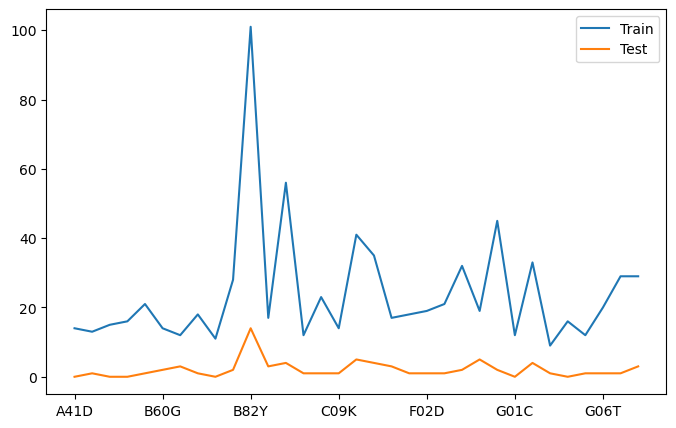

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_claim_train_l = df_claim_train.iloc[:, 7:]
df_claim_test_l = df_claim_test.iloc[:, 7:]

s = df_claim_train_l.sum()
d = df_claim_test_l.sum()

plt.figure(figsize=(8, 5))
s.plot(label='Train')
d.plot(label='Test')
plt.legend()  # 레이블 추가
plt.show()

In [213]:
# 분할된 데이터프레임을 CSV 파일로 저장
df_claim_train.to_csv("df_claim_train7.csv", index=False)
df_claim_test.to_csv("df_claim_test3.csv", index=False)

### 2단계: SBERT를 사용한 초기 임베딩 생성
다음 코드를 사용하여 PatentSBERTa 모델을 로드하고 임베딩을 생성

In [214]:
from sentence_transformers import SentenceTransformer

# PatentSBERTa 모델 로드
model = SentenceTransformer("AI-Growth-Lab/PatentSBERTa")

# 특허 청구 항목에 대한 임베딩 생성
train_embeddings = model.encode(df_claim_train["text"].tolist(), convert_to_tensor=True)
test_embeddings = model.encode(df_claim_test["text"].tolist(), convert_to_tensor=True)

# 생성된 임베딩 저장
torch.save(claim_embeddings, 'train_embeddings.pt')
torch.save(test_embeddings, 'test_embeddings.pt')

In [15]:
import torch
from sentence_transformers import SentenceTransformer, util

# 저장된 임베딩 불러오기
train_embeddings = torch.load('train_embeddings.pt')
test_embeddings = torch.load('test_embeddings.pt')

# PatentSBERTa 모델 로드
model = SentenceTransformer("AI-Growth-Lab/PatentSBERTa")

### 3단계: Augmented SBERT를 사용한 SBERT 강화

In [35]:
import time
from sentence_transformers import CrossEncoder, SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from tqdm import tqdm

start_time = time.time()

# Cross-Encoder 모델 로드
cross_encoder = CrossEncoder("roberta-base")

# 추가 훈련 데이터 생성
num_samples = 20
additional_training_data = []
for i in tqdm(range(num_samples), desc="Generating training data"):
    for j in range(i+1, num_samples):
        similarity_score = cross_encoder.predict([(df_claim_train["text"].iloc[i], df_claim_train["text"].iloc[j])])
        additional_training_data.append((df_claim_train["text"].iloc[i], df_claim_train["text"].iloc[j], similarity_score))

generation_time = time.time()
print(f"Data generation took {generation_time - start_time} seconds")

# SBERT 모델 미세 조정
bi_encoder = SentenceTransformer("AI-Growth-Lab/PatentSBERTa")
train_samples = [InputExample(texts=[data[0], data[1]], label=data[2]) for data in additional_training_data]
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model=bi_encoder)

# Training with tqdm progress bar
training_start_time = time.time()
for epoch in range(1):
    bi_encoder.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=1,
        warmup_steps=100,
        show_progress_bar=True
    )
training_end_time = time.time()
print(f"Training took {training_end_time - training_start_time} seconds")

bi_encoder.save('augmented_sbert_model')
total_end_time = time.time()
print(f"Total execution time was {total_end_time - start_time} seconds")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating training data: 100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


Data generation took 27.534865379333496 seconds


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/12 [00:00<?, ?it/s]

Training took 191.83520436286926 seconds
Total execution time was 220.53068447113037 seconds


### 4단계 : 특허 간 유사도 측정
augmented sbert를 이용해서 임베딩 생성 -> 유사도 계산

In [17]:
import scipy.spatial
import numpy as np
import os, json
import glob
import re
import torch
import pandas as pd

In [36]:
# 미세 조정된 모델 로드
augmented_sbert_model = SentenceTransformer('augmented_sbert_model')

# 임베딩 생성
train_embeddings_aug = augmented_sbert_model.encode(df_claim_train["text"].tolist(), convert_to_tensor=True)
test_embeddings_aug = augmented_sbert_model.encode(df_claim_test["text"].tolist(), convert_to_tensor=True)

# 유사도 계산
similarities = util.semantic_search(test_embeddings_aug, train_embeddings_aug, top_k=5)

In [37]:
df_claim_cpc_1000 = pd.read_csv("dcf.csv")
df = df_claim_cpc_1000.rename(columns={"cpc_section_id": "section_id", "cpc_subsection_id": "subsection_id","cpc_group_id": "group_id", "cpc_subgroup_id": "subgroup_id"})

In [38]:
df.head(2)

,pub_no,id,claim_no,text,dependencies,ind_flg,cpc_category,section_id,subsection_id,group_id,subgroup_id
0,20010000001,9725796,11,The method of claim 10 comprising up to about ...,10,0,inventional,B,B22,B22D,B22D25/06
1,20010000001,9725796,16,The method of claim 15 wherein said sec-butano...,15,0,inventional,B,B22,B22D,B22D25/06


In [39]:
total_patents = df.count()
total_patents

pub_no           913
id               913
claim_no         913
text             913
dependencies     726
ind_flg          913
cpc_category     913
section_id       913
subsection_id    913
group_id         913
subgroup_id      913
dtype: int64

In [40]:
claims = list(df.text)
patent_id = list(df.id)

In [41]:
def get_top_n_similar_patents_df(new_claim, claims):
    # embedder = SentenceTransformer('bert-base-nli-stsb-mean-tokens')
    embedder = SentenceTransformer('augmented_sbert_model')
#     embedder = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')
    query_embeddings = embedder.encode([new_claim])

#     query_embeddings = tokenizer([new_claim], padding=True, truncation=True, max_length=128, return_tensors='pt')

    # list of patent claims
    claim_embeddings = embedder.encode(claims)

    # get top 100 patent claims based on cosine similarity
    closest_n = 3
    distances = scipy.spatial.distance.cdist(query_embeddings, claim_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    # save similar patents info
    top_claim_ids = []
    top_claims = []
    top_similarity_scores = []


    print('New_claim: ' + new_claim + '\n')

    # Find the closest 100 patent claims for each query new_claim based on cosine similarity
    for idx, distance in results[0:closest_n]:
        top_claim_ids.append(patent_id[idx])
        top_claims.append(claims[idx])
        top_similarity_scores.append(round((1-distance), 4))
        print('Patent ID: ' + str(patent_id[idx]))
        print('PubMed Claim: ' + claims[idx])
        print('Similarity Score: ' + "%.4f" % (1-distance))
        print('\n')
        
    top_100_similar_patents_df = pd.DataFrame({
        'top_claim_ids': top_claim_ids,
        'cosine_similarity': top_similarity_scores,
        'claims': top_claims,
    })
    
    return top_100_similar_patents_df

In [251]:
new_claim = ['The computer-implemented method of claim 4 wherein the filtering criteria comprises a number of page groups in the page group list is greater than 1, and the representative rank is less than or equal to the exit-entry max paths. The computer-implemented method of claim 2 wherein the selecting of the top n unconverted session paths further comprises only selecting unconverted sessions that meet a filtering criteria. The computer-implemented method of claim 1 further comprising creating a master table that lists the set of load test scenarios and the think times that represents a distribution of paths taken by real users during the peak hour.']

In [42]:
new_claim = ['A processor comprising: a cache to store one or more instructions including an instruction to perform a multiplication of a first complex number and a second complex number. a decoder to decode the one or more instructions; a register file including a plurality of registers to store packed data including the first complex number and the second complex number; and one or more execution units to perform the one or more instructions, wherein the one or more execution units to generate a final result to include one or more dot-products in response to processing the instruction, wherein a first dot product is generated by multiplying lower portions of the first and second complex number and a second dot product is generated by multiplying upper portions of the first and second complex number, wherein a first result is generated by subtracting the second dot product from the first dot product, wherein a third dot product is generated by multiplying an upper portion of the first complex number with a lower portion of the second complex number and a fourth dot product is generated by multiplying a lower portion of the first complex number and an upper portion of the second complex number, wherein a second result is generated by adding the third and fourth dot product, wherein the final result is generated based on the first result and the second result.']

In [43]:
get_top_n_similar_patents_df = get_top_n_similar_patents_df(new_claim[0], claims)
get_top_n_similar_patents_df

New_claim: A processor comprising: a cache to store one or more instructions including an instruction to perform a multiplication of a first complex number and a second complex number. a decoder to decode the one or more instructions; a register file including a plurality of registers to store packed data including the first complex number and the second complex number; and one or more execution units to perform the one or more instructions, wherein the one or more execution units to generate a final result to include one or more dot-products in response to processing the instruction, wherein a first dot product is generated by multiplying lower portions of the first and second complex number and a second dot product is generated by multiplying upper portions of the first and second complex number, wherein a first result is generated by subtracting the second dot product from the first dot product, wherein a third dot product is generated by multiplying an upper portion of the first co

,top_claim_ids,cosine_similarity,claims
0,9726609,0.6874,"A system, comprising: a client having (a) a pr..."
1,9727068,0.6607,Apparatus for passing transient data among pro...
2,9727068,0.6600,The apparatus of claim 1 further comprising: a...


In [44]:
result = pd.concat([get_top_n_similar_patents_df, df], axis=1, join='inner')
result

,top_claim_ids,cosine_similarity,claims,pub_no,id,claim_no,text,dependencies,ind_flg,cpc_category,section_id,subsection_id,group_id,subgroup_id
0,9726609,0.6874,"A system, comprising: a client having (a) a pr...",20010000001,9725796,11,The method of claim 10 comprising up to about ...,10,0,inventional,B,B22,B22D,B22D25/06
1,9727068,0.6607,Apparatus for passing transient data among pro...,20010000001,9725796,16,The method of claim 15 wherein said sec-butano...,15,0,inventional,B,B22,B22D,B22D25/06
2,9727068,0.6600,The apparatus of claim 1 further comprising: a...,20010000001,9725796,4,The solvent mixture of claim 3 wherein said te...,3,0,inventional,B,B22,B22D,B22D25/06


In [45]:
df_claim_cpc_result = result.copy()

df_claim_cpc_result['section_id'] = df_claim_cpc_result['section_id'].str.replace('nan|[{}\s]','').str.split(',').apply(set).str.join(',').str.strip(',').str.replace(",{2,}",",")
df_claim_cpc_result['subsection_id'] = df_claim_cpc_result['subsection_id'].str.replace('nan|[{}\s]','').str.split(',').apply(set).str.join(',').str.strip(',').str.replace(",{2,}",",")
df_claim_cpc_result['group_id'] = df_claim_cpc_result['group_id'].str.replace('nan|[{}\s]','').str.split(',').apply(set).str.join(',').str.strip(',').str.replace(",{2,}",",")
df_claim_cpc_result['subgroup_id'] = df_claim_cpc_result['subgroup_id'].str.replace('nan|[{}\s]','').str.split(',').apply(set).str.join(',').str.strip(',').str.replace(",{2,}",",")

In [46]:
k_similar_patents = df_claim_cpc_result.nlargest(10, ['cosine_similarity'])

In [47]:
final_result_mod = k_similar_patents.mode()
# final_result_max = k_similar_patents.max()
print('Prediction for section_id of New Patent is: ', final_result_mod.iloc[0]['section_id'])
print('Prediction for section_id of New Patent is: ', k_similar_patents.iloc[0:10]['section_id'])
print('Prediction for subsection_id of New Patent is: ', k_similar_patents.iloc[0:10]['subsection_id'])
print('Prediction for group_id of New Patent is: ', k_similar_patents.iloc[0:10]['group_id'])
print('Prediction for subgroup_id of New Patent is: ', k_similar_patents.iloc[0:10]['subgroup_id'])

Prediction for section_id of New Patent is:  B
Prediction for section_id of New Patent is:  0    B
1    B
2    B
Name: section_id, dtype: object
Prediction for subsection_id of New Patent is:  0    B22
1    B22
2    B22
Name: subsection_id, dtype: object
Prediction for group_id of New Patent is:  0    B22D
1    B22D
2    B22D
Name: group_id, dtype: object
Prediction for subgroup_id of New Patent is:  0    B22D25/06
1    B22D25/06
2    B22D25/06
Name: subgroup_id, dtype: object
